### Push Notificatoin Time 의사결정

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
COLORS = sns.color_palette()

%matplotlib inline

In [2]:
# 막대차트 공용 함수
def plot_bar(df, xlabel, ylabel, title, figsize=(20, 10), color=COLORS[-1], rotation=45):
    plot = df.plot(kind='bar', color=color, figsize=figsize)
    plot.set_xlabel(xlabel, fontsize=15)
    plot.set_ylabel(ylabel, fontsize=15)
    plot.set_title(title, fontsize=15)
    plot.set_xticklabels(labels=df.index, rotation=rotation)

In [3]:
dtypes = {
    'UnitPrice': np.float32,
    'CustomerID': np.int32,
    'Quantity': np.int32
}

retail = pd.read_csv('./data/OnlineRetailClean.csv', dtype=dtypes)
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'], infer_datetime_format=True)
retail.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CheckoutPrice
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


#### 쿠폰 발송을 할때, push를 언제 보내는게 좋을까?
 
 - 현상태에서는 가장 많이 주문이 일어나는 시점에서 하는 것이 가장 직관적인 판단
   - 1. 데이터로 파악
   - 2. 가설 제시
   - 3. 가설 검증
   - 4. 1-3 반복
 - 시간(hour, minute)과 주로 관련되기 때문에 역시 InvoiceDate가 중요한 feature
   

In [4]:
order_by_hour = retail.set_index('InvoiceDate').groupby(lambda date: date.hour).count()['CustomerID']
order_by_hour

6         1
7       379
8      8690
9     21944
10    37997
11    49084
12    72065
13    64026
14    54118
15    45369
16    24089
17    13071
18     2928
19     3321
20      802
Name: CustomerID, dtype: int64

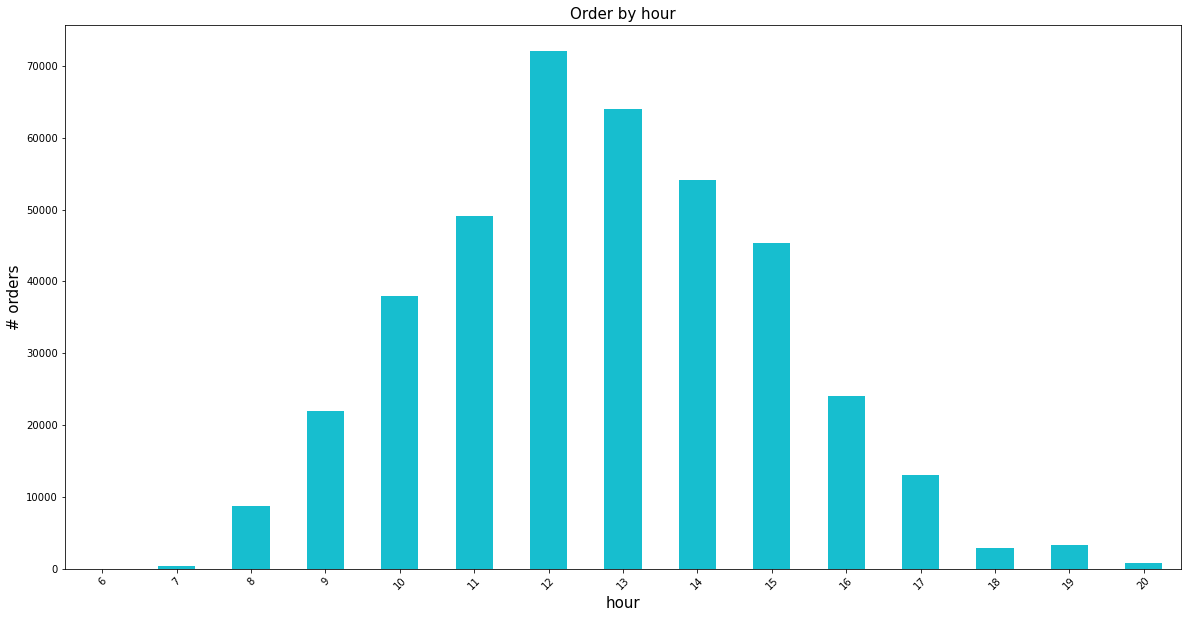

In [5]:
plot_bar(order_by_hour, 'hour', '# orders', 'Order by hour')

In [6]:
# 30분 단위 구분
def half_an_hour(date):
    minute = ':00'
    if date.minute > 30:
        minute = ':30'
    hour = str(date.hour)
    if date.hour < 10:
        hour = '0' + hour
    
    return hour + minute

In [7]:
order_by_hour_half = retail.set_index('InvoiceDate').groupby(half_an_hour).count()['CustomerID']
order_by_hour_half

06:00        1
07:30      379
08:00     3145
08:30     5545
09:00     9364
09:30    12580
10:00    16950
10:30    21047
11:00    18925
11:30    30159
12:00    37174
12:30    34891
13:00    31131
13:30    32895
14:00    26958
14:30    27160
15:00    24227
15:30    21142
16:00    14316
16:30     9773
17:00     8889
17:30     4182
18:00     1715
18:30     1213
19:00     1534
19:30     1787
20:00      802
Name: CustomerID, dtype: int64

In [8]:
# 비율
(order_by_hour_half / order_by_hour_half.sum()) * 100

# 12:00 ~ 13:00 사이는 전체의 18 % 밖에 되지 않으며, 다른 시간대를 합하면 그 비율이 더 크다.
# 시간대 기준이 아닌 고객 개인별 주문시간 고려해야 한다.

06:00    0.000251
07:30    0.095254
08:00    0.790431
08:30    1.393622
09:00    2.353450
09:30    3.161726
10:00    4.260036
10:30    5.289733
11:00    4.756411
11:30    7.579847
12:00    9.342924
12:30    8.769139
13:00    7.824140
13:30    8.267485
14:00    6.775342
14:30    6.826110
15:00    6.088961
15:30    5.313609
16:00    3.598034
16:30    2.456244
17:00    2.234068
17:30    1.051060
18:00    0.431030
18:30    0.304863
19:00    0.385540
19:30    0.449126
20:00    0.201566
Name: CustomerID, dtype: float64

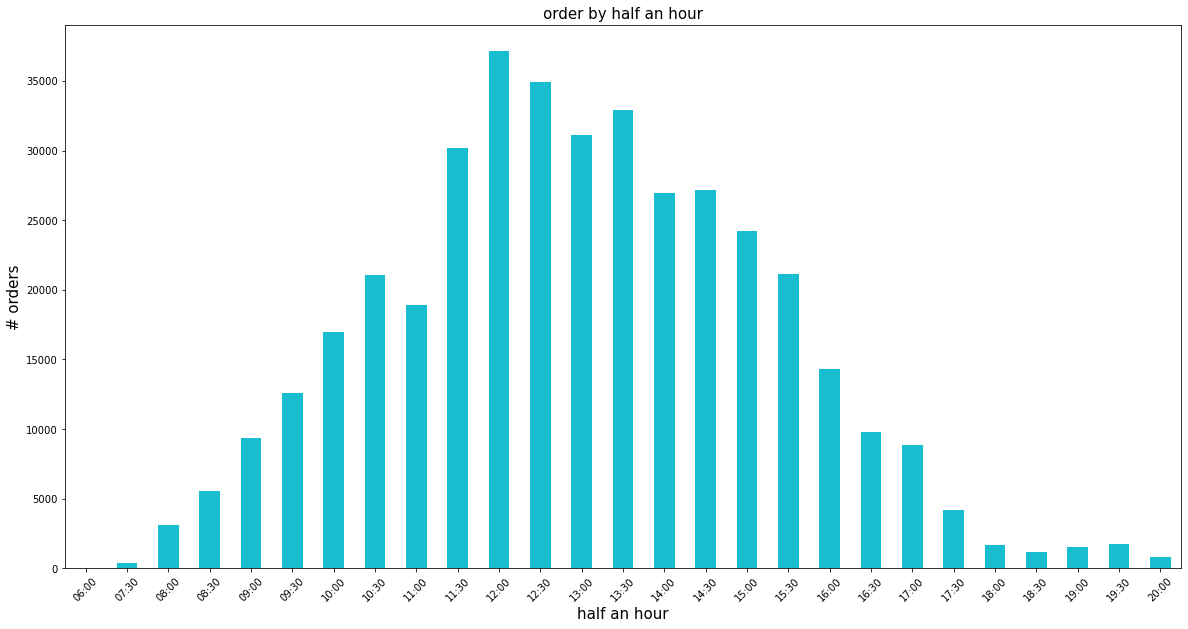

In [9]:
plot_bar(order_by_hour_half, 'half an hour', '# orders', 'order by half an hour')

#### 개인화된 push notification
 - 아마존을 필두로, 개인화(personalization)하여 맞춤으로 사용자마다 최적의 솔루션을 찾는것이 트렌드가 됨
 - 사용자별로 소비의 패턴이 다를 수 있기 때문에, 가장 많이 구매한 시간대를 찾아서 해당 시간대에 쿠폰을 발송!

#### 사용자별 각 시간별 주문 량 계산하기

In [10]:
order_count_by_hour = retail.set_index('InvoiceDate').groupby(['CustomerID', lambda date: date.hour]).count()['StockCode']
order_count_by_hour

CustomerID    
12346       10     1
12347       8     22
            10    24
            12    47
            13    18
                  ..
18283       15     1
            16    56
            19    87
18287       9      3
            10    67
Name: StockCode, Length: 11205, dtype: int64

In [11]:
order_count_by_hour.loc[12347]  # 이 고객의 최대 주문 시간은 14시...

8     22
10    24
12    47
13    18
14    60
15    11
Name: StockCode, dtype: int64

#### 사용자별 최대 주문 시간 계산하기
 - 가장 많은 주문량을 보인 시간을 계산

In [12]:
idx = order_count_by_hour.groupby('CustomerID').idxmax()  # 최대값 갖는 인덱스 반환 !!!
idx

CustomerID
12346    (12346, 10)
12347    (12347, 14)
12348    (12348, 19)
12349     (12349, 9)
12350    (12350, 16)
            ...     
18280     (18280, 9)
18281    (18281, 10)
18282    (18282, 13)
18283    (18283, 14)
18287    (18287, 10)
Name: StockCode, Length: 4338, dtype: object

#### 해당 시간 indexing

In [13]:
result = order_count_by_hour.loc[idx]
result

CustomerID    
12346       10      1
12347       14     60
12348       19     17
12349       9      73
12350       16     17
                 ... 
18280       9      10
18281       10      7
18282       13      7
18283       14    201
18287       10     67
Name: StockCode, Length: 4338, dtype: int64

In [14]:
# 인덱스 제거 후 시간대별로 그룹핑
hour_cust = result.reset_index().groupby('level_1').groups
hour_cust

{7: [73, 269, 319, 344, 375, 893, 1667, 2317], 8: [46, 58, 87, 126, 172, 179, 187, 260, 278, 279, 282, 292, 306, 347, 399, 429, 496, 503, 526, 533, 549, 552, 651, 671, 747, 755, 784, 792, 800, 803, 806, 821, 838, 877, 883, 920, 944, 947, 951, 954, 1008, 1093, 1106, 1120, 1138, 1172, 1173, 1217, 1251, 1397, 1422, 1424, 1436, 1472, 1512, 1616, 1621, 1666, 1668, 1678, 1687, 1734, 1759, 1761, 1774, 1791, 1815, 1827, 1846, 1859, 1895, 1900, 1903, 1996, 2018, 2023, 2054, 2085, 2108, 2117, 2167, 2172, 2253, 2380, 2383, 2403, 2404, 2417, 2427, 2462, 2464, 2643, 2749, 2776, 2781, 2896, 2936, 2949, 3021, 3130, ...], 9: [3, 9, 26, 30, 33, 35, 37, 48, 60, 66, 75, 84, 86, 90, 100, 106, 107, 121, 127, 135, 138, 142, 144, 146, 154, 159, 181, 199, 230, 240, 264, 265, 267, 277, 280, 286, 294, 298, 328, 333, 336, 342, 343, 352, 362, 366, 385, 402, 421, 459, 470, 475, 478, 482, 483, 509, 517, 519, 574, 603, 615, 630, 636, 642, 644, 691, 701, 706, 707, 746, 749, 752, 764, 770, 781, 783, 818, 825, 829, 844

In [15]:
# 15시에 많이 주문한 고객 리스트
print(len(hour_cust[15]))
print(hour_cust[15])

478
Int64Index([  13,   15,   17,   24,   65,   68,   91,   92,  117,  134,
            ...
            4260, 4262, 4276, 4279, 4293, 4305, 4312, 4314, 4323, 4331],
           dtype='int64', length=478)
